In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
from ast import literal_eval

In [3]:
df = pd.read_csv('data_wrangling.csv',
                 converters={'reviewClean_sw': literal_eval, 'reviewClean': literal_eval, 'noun_adjective': literal_eval})
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,reviewClean_sw,noun_adjective
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,"[exactly, what, i, need, .]",[]
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN,"[i, agree, with, the, other, review, ,, the, o...","[other, review, opening, small, hook, expensiv..."
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,"[love, these, ..., i, be, go, to, order, anoth...","[pack, work, someone, back, earring, fish, hoo..."
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,"[too, tiny, an, opening]","[tiny, opening]"
4,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,[okay],[]


**Cosine similarity threshold for aspect extraction**  
threshold should be data driven
- save all word-aspect similarities and take top 5%/10%, see if it make sense
- take 10 samples for the top %, evaluate pairs from the boundaries

In [4]:
df.shape

(852589, 14)

In [5]:
# drop reviews without extracted noun or adjective
df = df[df.noun_adjective.str.len() != 0]
df.shape

(811394, 14)

**Using word2vec model to calculate cosine similarity**

In [6]:
from gensim.models import KeyedVectors

# load the pretrained word2vec model as gensim keyedvectors
wv = KeyedVectors.load('word2vec-google-news-300', mmap='r')

# calculate and store the cosine similarities for all word-aspect pairs
aspects = ['color', 'design', 'material', 'price', 'quality', 'sizing']

def cosine_similarity(words):
    '''extract aspects using cosine similarity between tokens and each aspect'''
    cosine_similarity = dict()
    for word in words:
        if word in wv.vocab:
            for aspect in aspects:
                cosine_similarity[(word, aspect)] = abs(wv.similarity(word, aspect))
    return cosine_similarity

In [7]:
from tqdm import tqdm

tqdm.pandas()

df['word_aspect_similarity'] = df['noun_adjective'].progress_apply(cosine_similarity)

C:\Users\Billy\anaconda3\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|█████████████████████████████████████████████████████████████████████████| 811394/811394 [16:23<00:00, 824.86it/s]


In [8]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,reviewClean_sw,noun_adjective,word_aspect_similarity
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN,"[i, agree, with, the, other, review, ,, the, o...","[other, review, opening, small, hook, expensiv...","{('other', 'design'): 0.06390226, ('other', 'm..."
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,"[love, these, ..., i, be, go, to, order, anoth...","[pack, work, someone, back, earring, fish, hoo...","{('pack', 'design'): 0.07434415, ('pack', 'mat..."
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,"[too, tiny, an, opening]","[tiny, opening]","{('tiny', 'design'): 0.15835705, ('tiny', 'mat..."
6,4,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN,"[these, little, plastic, back, work, great, .,...","[little, plastic, back, loosing, hook, earring...","{('little', 'design'): 0.13715011, ('little', ..."
7,3,True,"09 22, 2013",A1BB77SEBQT8VX,B00007GDFV,Darrow H Ankrum II,mother - in - law wanted it as a present for h...,bought as a present,1379808000,NaN,{'Color:': ' Black'},NaN,"[mother, -, in, -, law, want, it, as, a, prese...","[mother, law, present, sister]","{('mother', 'design'): 0.038158633, ('mother',..."


In [9]:
from collections import ChainMap

# merge all word-aspect pairs into one dictionary
similarities = dict(ChainMap(*df['word_aspect_similarity']))

In [26]:
# caculate the number to get the top 0.1% of word-aspect pairs
n = int(len(similarities) * 0.001)

# sort all similarities from high to low, take the top 3% word-aspect pairs
top_similarities = dict(sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:n])
len(top_similarities)

142

In [27]:
boundary = sorted(top_similarities.items(), key=lambda item: item[1])[:10]
boundary

[(('cleanliness', 'quality'), 0.438488),
 (('accessibility', 'quality'), 0.43856126),
 (('textured', 'color'), 0.43909323),
 (('transluscent', 'color'), 0.44130194),
 (('metalic', 'color'), 0.44235858),
 (('resale', 'price'), 0.44305393),
 (('selecting', 'sizing'), 0.44357574),
 (('geometric', 'design'), 0.44386277),
 (('typographic', 'design'), 0.44394654),
 (('dye', 'color'), 0.44419786)]

In [28]:
import random

def sample_from_dict(dictionary, number, seed):
    random.seed(seed)
    samples = {}
    for key in random.sample(list(dictionary.keys()), number):
        samples[key] = dictionary[key]
    return samples

In [29]:
samples = sample_from_dict(top_similarities, 20, 42)
samples

{('pearlescent', 'color'): 0.5242644,
 ('designing', 'design'): 0.7195531,
 ('dichroic', 'color'): 0.47555807,
 ('conceptual', 'design'): 0.48532945,
 ('aesthetic', 'design'): 0.48699003,
 ('hue', 'color'): 0.5208082,
 ('deisgn', 'design'): 0.53097343,
 ('textured', 'color'): 0.43909323,
 ('tint', 'color'): 0.5416193,
 ('discount', 'price'): 0.45319015,
 ('architectural', 'design'): 0.6386297,
 ('pricing', 'price'): 0.6456747,
 ('matte', 'color'): 0.5415027,
 ('sepia', 'color'): 0.4936772,
 ('value', 'price'): 0.4866057,
 ('multicolored', 'color'): 0.444778,
 ('market', 'price'): 0.5026717,
 ('boxiness', 'design'): 0.4535754,
 ('blueish', 'color'): 0.49244845,
 ('haloing', 'color'): 0.45099705}

In [28]:
df.to_csv('aspect_extraction.csv', index=False)

**Using domain fasttext model to calculate cosine similarity**  
Train model after removing the stop words

In [35]:
reviewClean = pd.read_csv('data_wrangling.csv',
                 usecols=['reviewClean'],
                 converters={'reviewClean': literal_eval})
reviewClean.head()

,reviewClean
0,"[exactly, need]"
1,"[agree, review, opening, small, bend, hook, ex..."
2,"[love, go, order, pack, work, include, lose, e..."
3,"[tiny, opening]"
4,[okay]


In [36]:
from gensim.models.fasttext import FastText

embedding_size = 60
worker_number = 12
window_size = 40
min_word = 5
down_sampling = 1e-2

ft_model = FastText(reviewClean['reviewClean'],
                      size=embedding_size,
                      workers=worker_number,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

In [37]:
ft_model.save('fasttext_domain_model')

In [38]:
# calculate and store the cosine similarity for all word-aspect pairs
aspects = ['color', 'design', 'material', 'price', 'quality', 'sizing']

def cosine_similarity_ftdomain(words):
    '''extract aspects using cosine similarity between tokens and each aspect'''
    cosine_similarity = dict()
    for word in words:
        if word in ft_model.wv.vocab:
            for aspect in aspects:
                cosine_similarity[(word, aspect)] = abs(ft_model.wv.similarity(word, aspect))
    return cosine_similarity

In [39]:
from tqdm import tqdm

tqdm.pandas()

df['word_aspect_similarity_ftdomain'] = df['noun_adjective'].progress_apply(cosine_similarity_ftdomain)

C:\Users\Billy\anaconda3\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████| 811394/811394 [10:55<00:00, 1237.69it/s]


In [40]:
from collections import ChainMap

# merge all word-aspect pairs into one dictionary
similarities_ftdomain = dict(ChainMap(*df['word_aspect_similarity_ftdomain']))

In [41]:
# caculate the number for the top 0.1% of word-aspect pairs
n = int(len(similarities_ftdomain) * 0.001)

# sort all similarities from high to low, take the top 5% word-aspect pairs
top_similarities_ftdomain = dict(sorted(similarities_ftdomain.items(), key=lambda item: item[1], reverse=True)[:n])

In [133]:
samples_ftdomain = sample_from_dict(top_similarities_ftdomain, 20, 42)
samples_ftdomain

{('equivalent', 'sizing'): 0.79520094,
 ('teal', 'color'): 0.8745486,
 ('design', 'design'): 1.0,
 ('quality-', 'quality'): 0.82936424,
 ('make', 'design'): 0.83632624,
 ('unique', 'design'): 0.8461783,
 ('quality', 'price'): 0.8629768,
 ('purple', 'color'): 0.87873244,
 ('plum', 'color'): 0.7932322,
 ('stretchy', 'material'): 0.8040991,
 ('red', 'color'): 0.8853427,
 ('pattern', 'color'): 0.79887587,
 ('quailty', 'quality'): 0.8142344,
 ('color', 'color'): 0.99999994,
 ('coloring', 'color'): 0.8471998,
 ('peach', 'color'): 0.84299254,
 ('xxl', 'sizing'): 0.80726933,
 ('happy', 'price'): 0.7986858,
 ('deep', 'color'): 0.80359685,
 ('grey', 'color'): 0.84927994}

**Aspect Extraction**

In [134]:
def aspect_extraction(data):
    '''extract word-aspect pairs and aspects using 0.4 as the threshold for similarity'''
    pair_list = []
    aspect_list = []
    for (word, aspect), similarity in data.items():
        if similarity >= 0.40 and aspect not in aspect_list:
            pair_list.append((word, aspect))
            aspect_list.append(aspect)
        elif similarity >= 0.40 and aspect in aspect_list:
            pair_list.append((word, aspect))
            
    if len(aspect_list) == 0:
        aspect_list.append('general')
        
    return pair_list, aspect_list

In [135]:
from tqdm import tqdm

tqdm.pandas()
# apply the helper function to extract aspect terms and aspects
df['pair'], df['aspect'] = zip(*df['word_aspect_similarity'].progress_apply(aspect_extraction))

df.head()

C:\Users\Billy\anaconda3\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████| 811394/811394 [02:12<00:00, 6107.54it/s]


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,reviewClean_sw,noun_adjective,word_aspect_similarity,word_aspect_similarity_ftdomain,pair,aspect
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN,"[i, agree, with, the, other, review, ,, the, o...","[other, review, opening, small, hook, expensiv...","{('other', 'design'): 0.06390226, ('other', 'm...","{('review', 'color'): 0.47370848, ('review', '...","[(price, price)]",[price]
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,"[love, these, ..., i, be, go, to, order, anoth...","[pack, work, someone, back, earring, fish, hoo...","{('pack', 'design'): 0.07434415, ('pack', 'mat...","{('pack', 'color'): 0.45599386, ('pack', 'desi...",[],[general]
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,"[too, tiny, an, opening]","[tiny, opening]","{('tiny', 'design'): 0.15835705, ('tiny', 'mat...","{('tiny', 'color'): 0.41614622, ('tiny', 'desi...",[],[general]
6,4,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN,"[these, little, plastic, back, work, great, .,...","[little, plastic, back, loosing, hook, earring...","{('little', 'design'): 0.13715011, ('little', ...","{('little', 'color'): 0.67847776, ('little', '...",[],[general]
7,3,True,"09 22, 2013",A1BB77SEBQT8VX,B00007GDFV,Darrow H Ankrum II,mother - in - law wanted it as a present for h...,bought as a present,1379808000,NaN,{'Color:': ' Black'},NaN,"[mother, -, in, -, law, want, it, as, a, prese...","[mother, law, present, sister]","{('mother', 'design'): 0.038158633, ('mother',...","{('mother', 'color'): 0.4880516, ('mother', 'd...",[],[general]


In [136]:
df.to_csv('aspect_extraction.csv', index=False)

**Top Aspect Term Visualization**

In [137]:
from collections import Counter
from collections import defaultdict

aspects = ['color', 'design', 'material', 'price', 'quality', 'sizing']

# helper function to extract the most frequent aspect terms for each aspect
def top_terms(data):
    counter = Counter(data.explode().dropna())
    dic = defaultdict(dict)
    for (term, aspect), count in counter.items():
        dic[aspect][term] = count
    
    top_terms = []
    term_aspect = []

    for aspect in aspects:
        for term in sorted(dic[aspect], key=dic[aspect].get, reverse=True)[:15]:
            top_terms.append(term)
            term_aspect.append(aspect)
    return top_terms, term_aspect

In [138]:
# get the top aspect terms and their aspects
top_terms, term_aspect = top_terms(df['pair'])

In [139]:
temp = pd.DataFrame()
temp['term'] = top_terms
temp['aspect'] = term_aspect
temp.head()

,term,aspect
0,color,color
1,black,color
2,white,color
3,blue,color
4,red,color


In [140]:
temp.groupby(temp.term).size().sort_values(ascending=False)

term
craftsmanship    2
workmanship      2
market           1
layout           1
kitting          1
                ..
pink             1
picking          1
paint            1
overpriced       1
adjusting        1
Length: 66, dtype: int64

In [141]:
temp[(temp.term == 'craftsmanship') | (temp.term == 'workmanship')]

,term,aspect
16,workmanship,design
17,craftsmanship,design
49,workmanship,quality
51,craftsmanship,quality


In [142]:
wv.similarity('workmanship', 'design'), wv.similarity('workmanship', 'quality')

(0.47201687, 0.4499731)

In [143]:
wv.similarity('craftsmanship', 'design'), wv.similarity('craftsmanship', 'quality')

(0.45257074, 0.41578835)

In [144]:
temp = temp.drop(index=[49, 51])
top_terms = list(temp.term)
term_aspect = list(temp.aspect)

In [147]:
from sklearn.decomposition import PCA

# instantiate a PCA object
pca = PCA(n_components=2)

# fit and transform 300 features to 2 principle components
top_terms_pca = pca.fit_transform(wv[top_terms])

# create a dataframe for visualization
df_pca = pd.DataFrame(top_terms_pca, index=top_terms)
df_pca['aspect'] = term_aspect

df_pca.head()

,0,1,aspect
color,1.294417,0.041136,color
black,1.145243,-0.651380,color
white,1.199676,-0.689129,color
blue,1.534748,-0.725898,color
red,1.372235,-0.911072,color


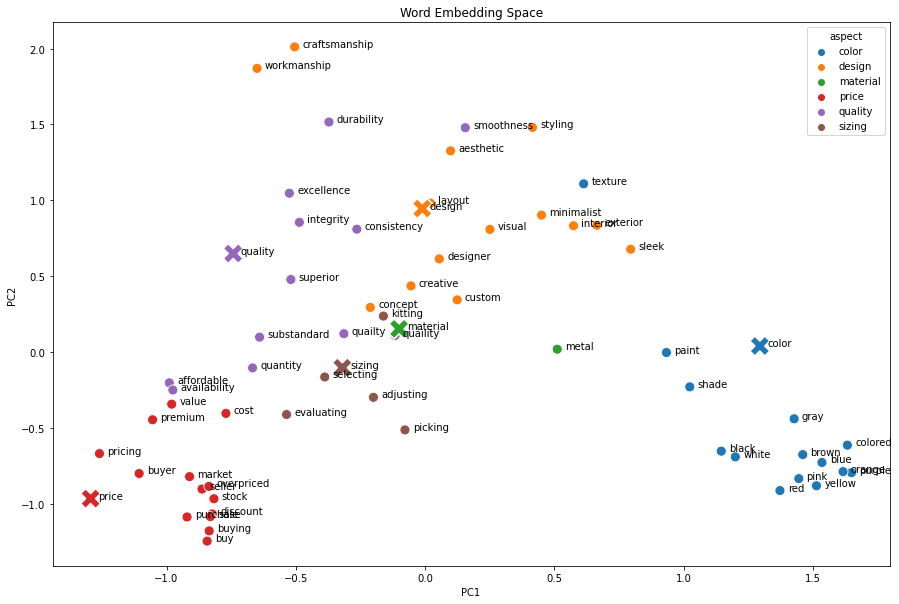

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))

# scatter plot for each aspect term
sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=df_pca['aspect'], palette=["C0", "C1", "C2", "C3", "C4", "C5"], s=100)

# scatter plot for each aspect
sns.scatterplot(x=df_pca.loc[aspects][0], y=df_pca.loc[aspects][1], 
                hue=df_pca.loc[aspects]['aspect'], palette=["C0", "C1", "C2", "C3", "C4", "C5"], 
                marker='X', s=400, legend=None)

# plt.legend(loc='lower right')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Word Embedding Space")

for term in top_terms:
    plt.annotate(term, xy=(df_pca.loc[term][0], df_pca.loc[term][1]),
                 xytext=(df_pca.loc[term][0]+0.03, df_pca.loc[term][1]))